# Introducción:
# Microproyecto 4

**Integrantes del equipo 7:**

* Santiago Cano Vásquez
* Duberney Gutierrez Bacca

In [ ]:
#Accedemos al drive donde esta la carpeta requerida
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Importar las librerías necesarias:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pickle para los datasets
import pickle

# Librerias para manejo de imagenes y matrices
import math
import random
import pandas as pd
import numpy as np
import scipy
from scipy import ndimage
import time
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import cv2
from __future__ import absolute_import, division, print_function, unicode_literals

# Librerias TensorFlow y tf.keras para manejo del modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.models import load_model
from tensorflow.python.framework import ops

# Librerias para matriz de confusion y metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Version de TensorFlow: "+str(tf.__version__))

Version de TensorFlow: 2.14.0


In [ ]:
#importamos libreria necesaria
from os import listdir
import os

#Carga imágenes desde un directorio, las procesa y devuelve los datos.
def Cargar_img(directorio: str, img_size: tuple[int, int], color_mode: str):

    X, y = [], []
    class_names = listdir(directorio)
    for i, img_fold in enumerate(class_names):

        images_path = listdir(os.path.join(directorio, img_fold))
        y.extend([i]*len(images_path))
        for img_name in images_path:
            image = tf.keras.utils.load_img(
                os.path.join(directorio, img_fold, img_name),
                color_mode = color_mode,
                target_size= img_size,
                interpolation="nearest",
                keep_aspect_ratio=False,
            )

            image = tf.keras.utils.img_to_array(image, data_format="channels_last").astype(np.uint8)

            X.append(image)

    print("clases encontradas:", class_names)
    X = np.array(X)
    y = np.array(y)

    i = np.arange(0, y.shape[0])
    np.random.shuffle(i)

    return X[i], y[i], class_names

In [ ]:
#Este código carga imágenes desde un directorio específico en Google Drive, ajustando su tamaño a 256x256 píxeles y utilizando el modo de color RGB.
X, y, clases = Cargar_img(
    directorio = '/content/drive/MyDrive/Microproyecto 4 - IA/archive1',
    img_size = (256,256),
    color_mode = "rgb"
)

clases encontradas: ['Tuberculoma', 'NORMAL', 'Carcinoma', 'Germinoma', 'Papiloma', 'Meduloblastoma', 'Oligodendroglioma', 'Ganglioglioma', 'Meningioma', 'Glioblastoma', 'Neurocitoma', 'Granuloma', 'Ependimoma', 'Schwannoma', 'Astrocitoma']


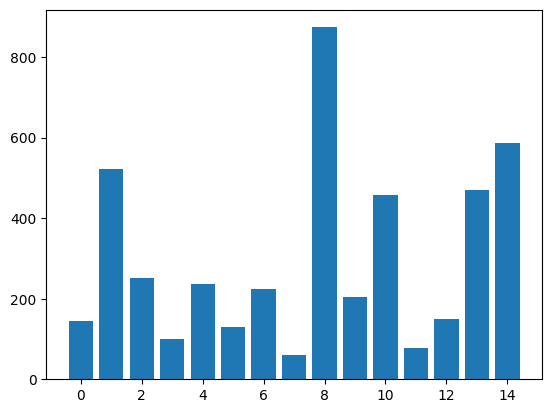

In [ ]:
#generar un gráfico de barras
plt.figure()

plt.bar(np.arange(15), np.bincount(y))

plt.show()

Tenemos 15 clases muy desbalanceadas, más tarde tendremos que tratar con eso

In [ ]:
X_train = X[:int(len(X)*.8)]
y_train = y[:int(len(X)*.8)]
X_test = X[int(len(X)*.8):]
y_test = y[int(len(X)*.8):]

Partimos en train y test de esta manera porque la función de sklearn consume demasiados recursos, ocurre lo mismo al reescalar los valores de las imagenes entre 0 y 1, entonces hacemos esto dentro de la red como una capa de preprocesamiento

In [ ]:
#Construir el modelo de la CNN:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255, input_shape=(256, 256, 3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation='relu'),
    tf.keras.layers.Dense(len(clases), activation='softmax')
])

También usamos una capa RandomFlip como una forma de Data Augmentation, el resto de la red consiste en tres capas convolucionales seguidas de capas maxPooling, usamos regularización l2 en las capas convolucionales, luego usamos una capa flatten para que pueda ser usada por las capas densas, en este caso usamos una de 128 unidades y regularización l2, finalmente tenemos la capa de salida con función de activación softmax.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

In [ ]:
#Compilar y entrenar el modelo:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Los callbacks son herramientas útiles en el entrenamiento de modelos de CNN que nos permiten realizar acciones en ciertos puntos clave durante el entrenamiento.

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=0.001)

El callback ReduceLROnPlateau reduce la taza de entrenamiento, es decir el párametro del optimizador de decenso por el gradiente, ya que podría estar cerca de un mínimo, mientras que EarlyStopping detiene el entrenamiento si no hay mejoras en la métrica de validación durante un número determinado de épocas.

Debido al desbalanceo de las clases vamos a encontrar los pesos de las clases para pasarselos a la red en entrenamiento

In [ ]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)))

class_weights

{0: 1.9785123966942149,
 1: 0.5853300733496333,
 2: 1.2534031413612565,
 3: 3.109090909090909,
 4: 1.3010869565217391,
 5: 2.1763636363636363,
 6: 1.3081967213114754,
 7: 5.093617021276596,
 8: 0.3376586741889986,
 9: 1.4687116564417177,
 10: 0.6452830188679245,
 11: 3.4695652173913043,
 12: 2.046153846153846,
 13: 0.6218181818181818,
 14: 0.5261538461538462}

Ahora entrenamos la red, le damos un 15% como conjunto de validación, le pasamos los callbacks y los pesos de las clases

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.15, epochs=20, callbacks=[early_stopping_callback,reduce_lr],class_weight=class_weights)

Epoch 1/20
96/96 [==============================] - 19s 76ms/step - loss: 2.3330 - accuracy: 0.1868 - val_loss: 2.0276 - val_accuracy: 0.3506 - lr: 0.0010
Epoch 2/20
96/96 [==============================] - 6s 66ms/step - loss: 1.5272 - accuracy: 0.4499 - val_loss: 1.5240 - val_accuracy: 0.5158 - lr: 0.0010
Epoch 3/20
96/96 [==============================] - 6s 67ms/step - loss: 0.9838 - accuracy: 0.6189 - val_loss: 1.3786 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 4/20
96/96 [==============================] - 6s 64ms/step - loss: 0.6615 - accuracy: 0.7153 - val_loss: 0.9964 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 5/20
96/96 [==============================] - 7s 69ms/step - loss: 0.5038 - accuracy: 0.7942 - val_loss: 0.9109 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 6/20
96/96 [==============================] - 6s 66ms/step - loss: 0.3520 - accuracy: 0.8512 - val_loss: 0.7686 - val_accuracy: 0.7904 - lr: 0.0010
Epoch 7/20
96/96 [==============================] - 6s 66ms/step - loss: 0.

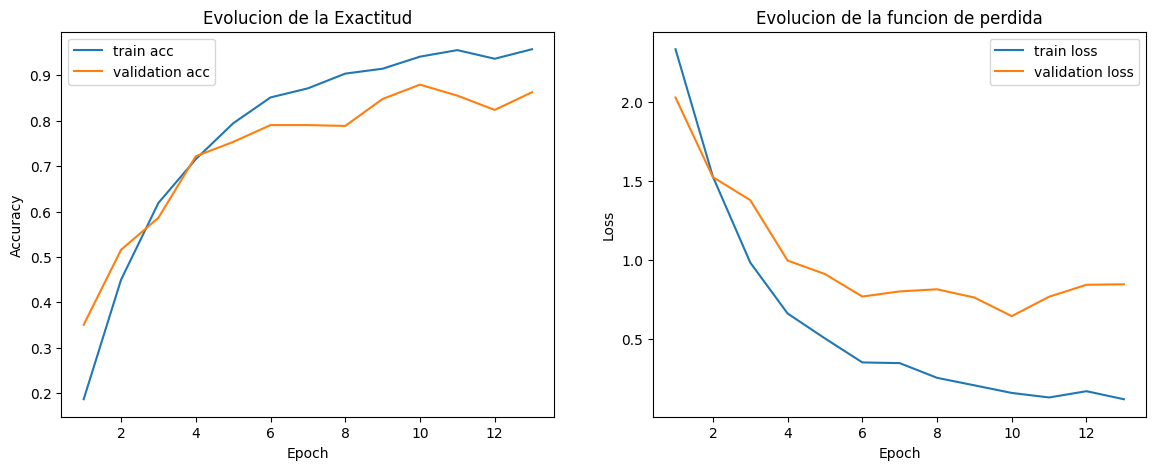

In [ ]:
# graficas de la evolucion del acurracy y loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = history.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()

Mapa de características (feature map):

Para obtener el mapa de características de las primeras 3 capas convolucionales.

1/1 [==============================] - 0s 188ms/step


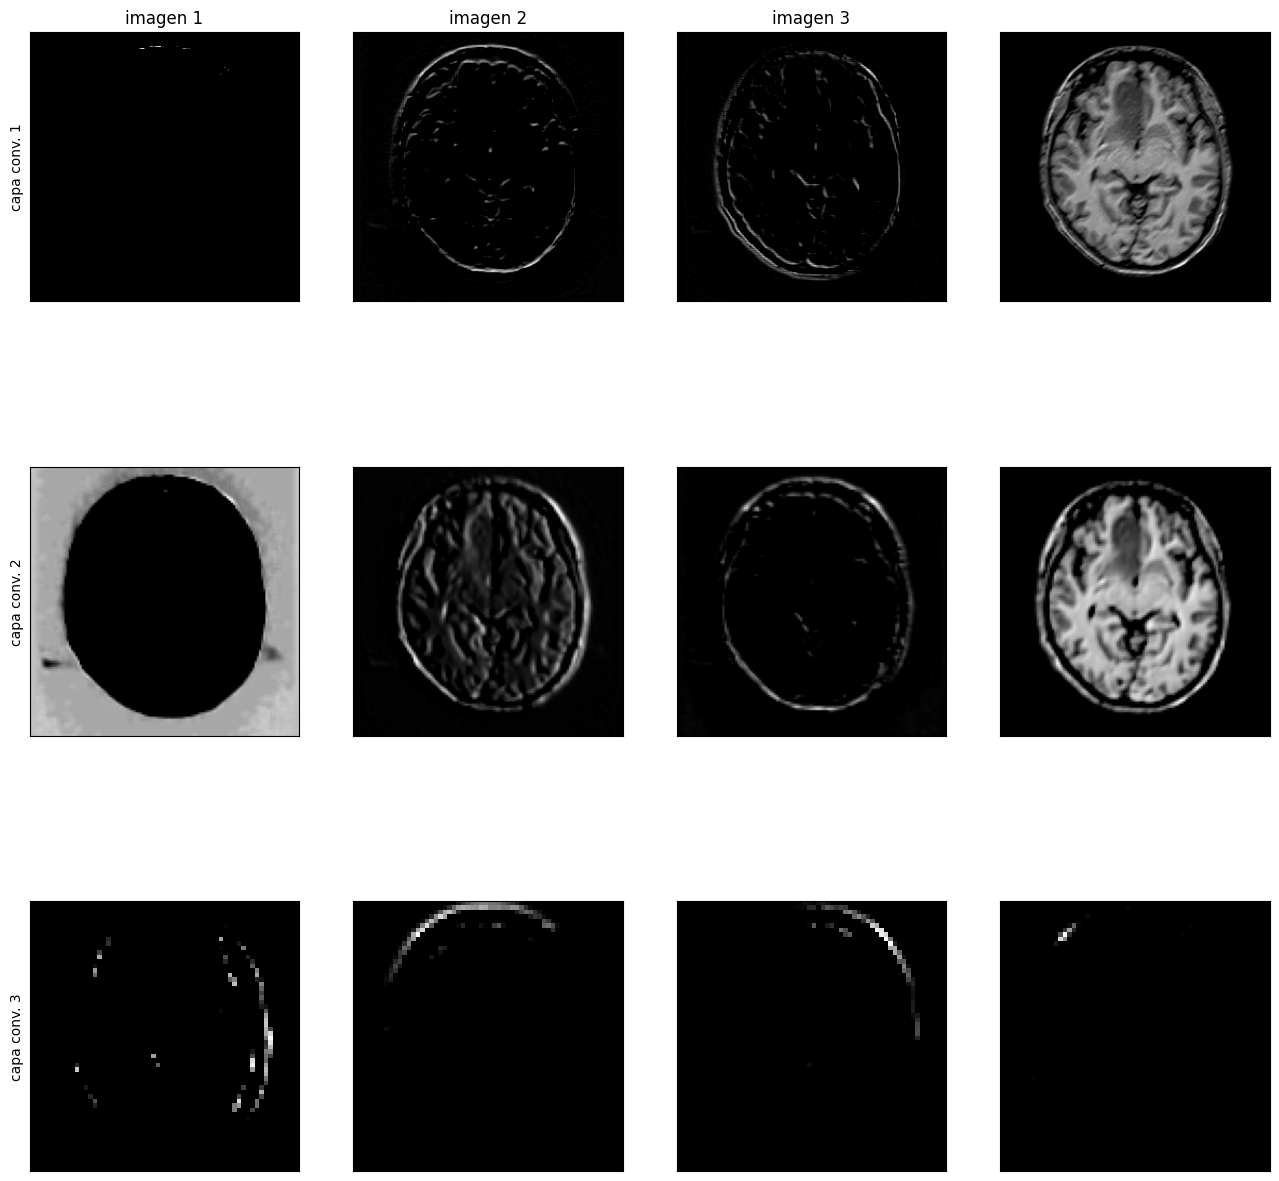

In [ ]:
conv_layers = [layer for layer in model.layers if "conv" in layer.name ]

_, axes = plt.subplots(len(conv_layers), 4, figsize=(16,16))

np.random.seed(3)

# modelo que nos dara la salida de cada capa convolucional
vis_model = tf.keras.models.Model(
    inputs = model.input,
    outputs = [ layer.output for layer in conv_layers ]
)

# aplicar el modelo hasta cada capa convolucional
feature_maps = vis_model.predict( np.expand_dims(X_test[40], axis=0) )

for i, f_map in enumerate(feature_maps):
    axes[i,0].set_ylabel(f"capa conv. {i+1}")
    axes[0,i].set_title(f"imagen {i+1}")

    # filtrar imagenes resultantes sin caracteristicas extraidas
    f_map = f_map[:,:,:, np.any(f_map[0,:,:,:] > 0, axis=(0,1)) ]

    # seleccionar 4 imagenes con el filtro aplicado para mostrar
    sel = np.random.randint(0, f_map.shape[-1], 4)
    feature_map_selected = f_map[:,:,:, sel]
    feature_map_selected = feature_map_selected[0]
    feature_map_selected = np.moveaxis(feature_map_selected, -1, 0)
    for j, image in enumerate(feature_map_selected):
        # visualizar imagen
        axes[i,j].imshow(image, cmap="gray")

        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

plt.show()

Observarás que cada capa convolucional aprende diferentes patrones o características de las imágenes. En este caso parece que las capas aprenden de características más generales a más especificas y localizadas.

Después de entrenar el modelo, calculamos la matriz de confusión y las métricas de desempeño utilizando los datos de validación.


ENTRENAMIENTO Y VALIDACION:

113/113 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       121
           1       0.98      0.96      0.97       409
           2       0.96      0.99      0.97       191
           3       0.91      1.00      0.95        77
           4       0.78      0.99      0.87       184
           5       0.95      0.99      0.97       110
           6       0.95      0.98      0.96       183
           7       0.96      0.94      0.95        47
           8       0.98      0.85      0.91       709
           9       0.97      0.93      0.95       163
          10       0.94      0.99      0.96       371
          11       0.97      0.97      0.97        69
          12       0.98      0.93      0.96       117
          13       0.97      0.98      0.98       385
          14       0.96      0.95      0.96       455

    accuracy                           0.95     

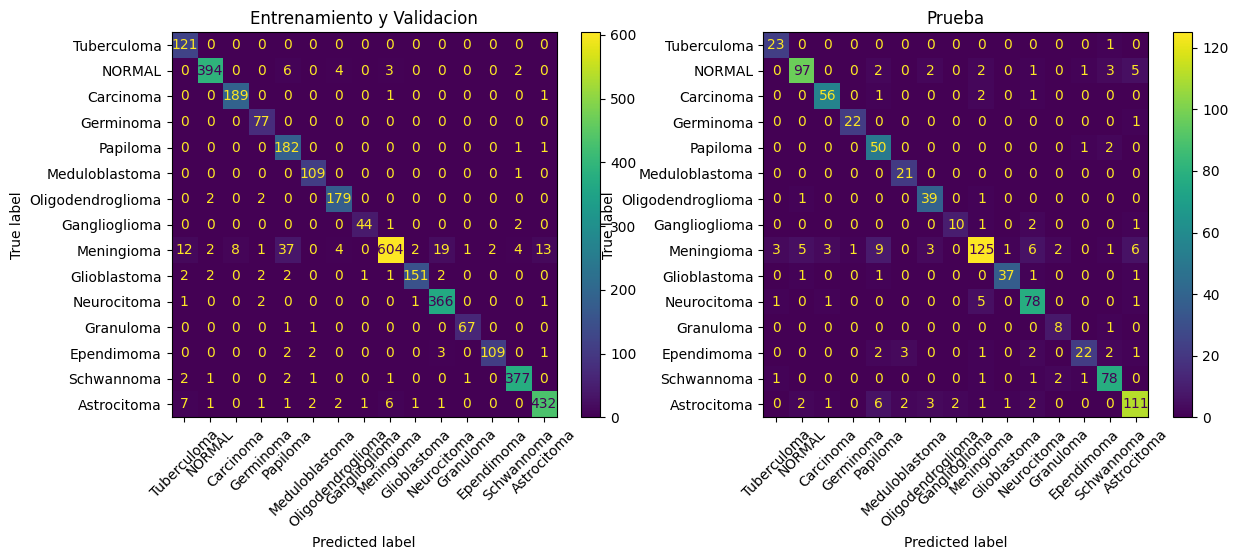

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

print("\nENTRENAMIENTO Y VALIDACION:\n")

y_pred = np.argmax(model.predict(X_train), axis=1)

print(classification_report(y_train, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_train,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax1
)

ax1.tick_params(axis='x', rotation=45)

ax1.set_title("Entrenamiento y Validacion")

print("\nPRUEBA:\n")

y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax2
)

ax2.tick_params(axis='x', rotation=45)

ax2.set_title("Prueba")

plt.show()

Utilice una CNN preentrenada tal como ResNet-50, ResNet-100, Xception,
Inception-ResNet-v2, etc. para la clasificación de sus imágenes, utilizando el mismo
Dataset de la CNN del punto 4. Analice los resultados obtenidos al comparar los
resultados de las métricas de desempeño Exactitud (Accuracy), Precisión, Sensibilidad
(Recall), f1-Score. Concluya sobre las ventajas en la utilización o no, de estas redes
preentrenadas.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential


# Cargar la red preentrenada (weights='imagenet' carga los pesos preentrenados en ImageNet)
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model = VGG16(weights='imagenet', include_top=False)

# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas adicionales para la clasificación
tf_model = Sequential()
tf_model.add(tf.keras.layers.RandomFlip("horizontal_and_vertical",input_shape=(256, 256, 3)))
tf_model.add(base_model)
tf_model.add(tf.keras.layers.Flatten())
tf_model.add(tf.keras.layers.Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
tf_model.add(tf.keras.layers.Dense(len(clases), activation='softmax'))

tf_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dense_3 (Dense)             (None, 15)                1935      
                                                                 
Total params: 18911055 (72.14 MB)
Trainable params: 4196367 (16.01 MB)
Non-trainable params: 14714688 (56.13 MB)
________

In [ ]:
tf_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tf_history = tf_model.fit(X_train, y_train, validation_split=0.15, epochs=20, callbacks=[early_stopping_callback,reduce_lr],class_weight=class_weights)

Epoch 1/20
96/96 [==============================] - 33s 294ms/step - loss: 11.9860 - accuracy: 0.1245 - val_loss: 2.6504 - val_accuracy: 0.0798 - lr: 0.0010
Epoch 2/20
96/96 [==============================] - 22s 225ms/step - loss: 2.4320 - accuracy: 0.1576 - val_loss: 2.5271 - val_accuracy: 0.1577 - lr: 0.0010
Epoch 3/20
96/96 [==============================] - 22s 229ms/step - loss: 2.3573 - accuracy: 0.2031 - val_loss: 2.8134 - val_accuracy: 0.1558 - lr: 0.0010
Epoch 4/20
96/96 [==============================] - 19s 197ms/step - loss: 2.2808 - accuracy: 0.2100 - val_loss: 2.4537 - val_accuracy: 0.1725 - lr: 0.0010
Epoch 5/20
96/96 [==============================] - 21s 221ms/step - loss: 2.1812 - accuracy: 0.2251 - val_loss: 2.4551 - val_accuracy: 0.1892 - lr: 0.0010
Epoch 6/20
96/96 [==============================] - 21s 223ms/step - loss: 2.2546 - accuracy: 0.2228 - val_loss: 2.5335 - val_accuracy: 0.1688 - lr: 0.0010
Epoch 7/20
96/96 [==============================] - 22s 226ms/s

En este ejemplo, utilizamos la red preentrenada VGG16, cargando los pesos preentrenados en el conjunto de datos de ImageNet. Luego, congelamos las capas preentrenadas para que no se actualicen durante el entrenamiento. Agregamos capas adicionales para la clasificación, que incluyen una capa de flatten y dos capas densas, una de ellas con activación relu y regularización l2 y la otra con activación softmax.

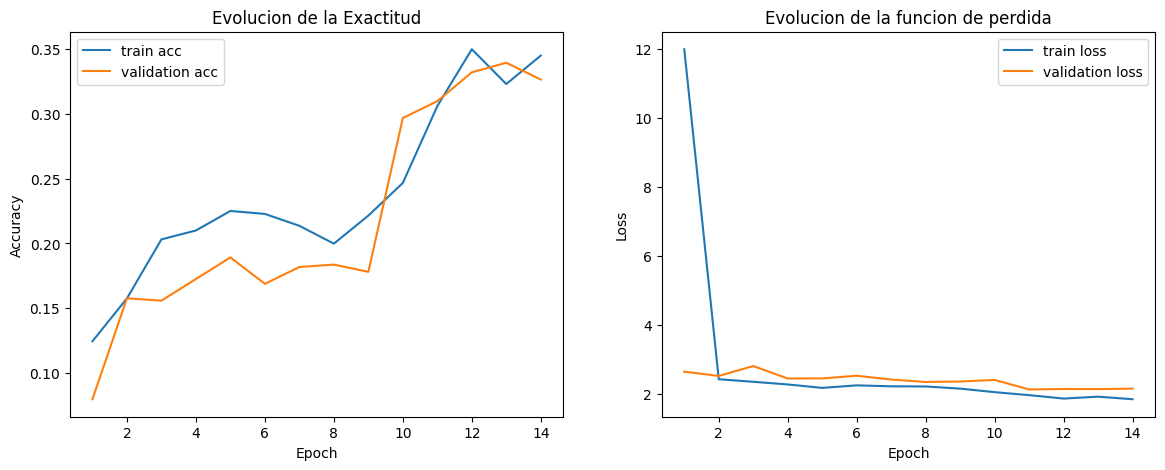

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

history = tf_history.history
epochs = range(1, len(history["accuracy"]) + 1)

# plot acurracy
ax1.plot(epochs, history["accuracy"], label="train acc")
ax1.plot(epochs, history["val_accuracy"], label="validation acc")

ax1.legend()
ax1.set_title("Evolucion de la Exactitud")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")


# plot loss
ax2.plot(epochs, history["loss"], label="train loss")
ax2.plot(epochs, history["val_loss"], label="validation loss")

ax2.legend()
ax2.set_title("Evolucion de la funcion de perdida")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")

plt.show()


ENTRENAMIENTO Y VALIDACION:

113/113 [==============================] - 20s 173ms/step
              precision    recall  f1-score   support

           0       1.00      0.44      0.61       121
           1       0.48      0.03      0.06       409
           2       0.66      0.88      0.76       191
           3       0.40      0.16      0.22        77
           4       0.68      0.43      0.53       184
           5       1.00      0.17      0.29       110
           6       0.19      0.04      0.07       183
           7       0.71      0.62      0.66        47
           8       0.69      0.04      0.08       709
           9       0.72      0.36      0.48       163
          10       0.49      0.85      0.62       371
          11       1.00      0.49      0.66        69
          12       0.21      0.05      0.08       117
          13       0.57      0.15      0.24       385
          14       0.18      0.84      0.30       455

    accuracy                           0.35   

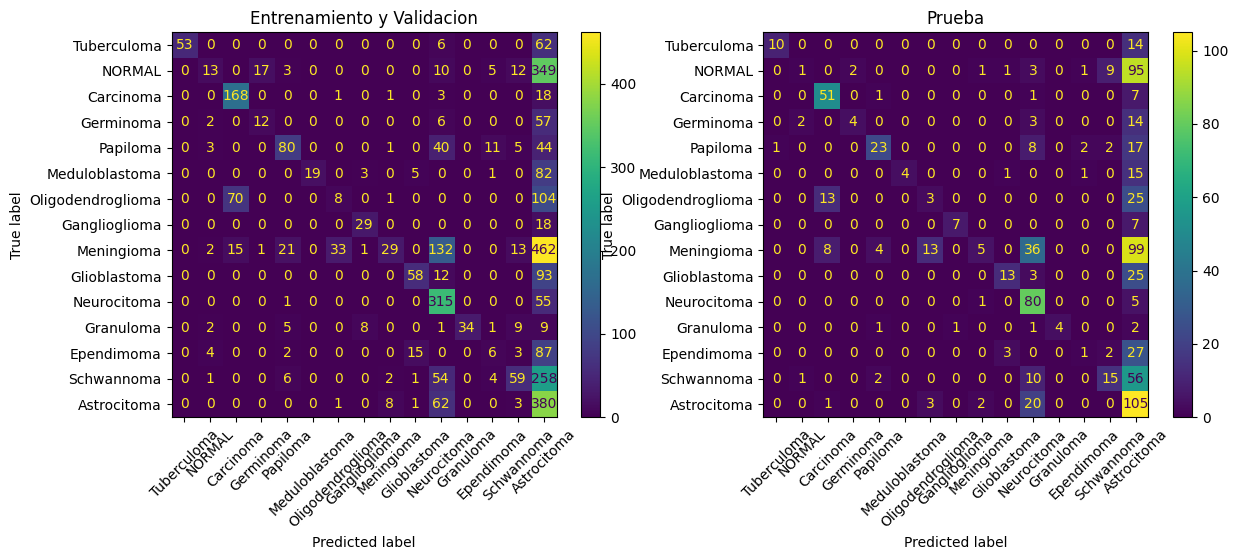

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

print("\nENTRENAMIENTO Y VALIDACION:\n")

y_pred = np.argmax(tf_model.predict(X_train), axis=1)

print(classification_report(y_train, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_train,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax1
)

ax1.tick_params(axis='x', rotation=45)

ax1.set_title("Entrenamiento y Validacion")

print("\nPRUEBA:\n")

y_pred = np.argmax(tf_model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred,
    display_labels = clases,
    ax = ax2
)

ax2.tick_params(axis='x', rotation=45)

ax2.set_title("Prueba")

plt.show()

# **Análisis**


**Comparación de Métricas de Desempeño:**

`*Modelo Personalizado:*`

**Exactitud (Accuracy):**

* Entrenamiento: ~95%
* Validación: ~95%
* Prueba: ~87%

**Precisión, Sensibilidad (Recall) y F1-Score:**

El modelo personalizado mostró buen rendimiento en términos de precisión, sensibilidad y F1-Score para varias clases.

Algunas clases tuvieron un rendimiento excepcionalmente bueno, mientras que otras tuvieron puntuaciones más bajas.

`**Modelo Preentrenado VGG16:**`

**Exactitud (Accuracy):**

* Entrenamiento: ~35%
* Validación: ~36%
* Prueba: ~36%

**Precisión, Sensibilidad (Recall) y F1-Score:**

El modelo preentrenado VGG16 tuvo dificultades para adaptarse a las características específicas del conjunto de datos.

El rendimiento fue más bajo en términos de precisión, sensibilidad y F1-Score en comparación con el modelo personalizado.


`Ventajas de la Utilización de Redes Preentrenadas:`

**Transferencia de Conocimiento:**

* Modelo Personalizado: Requiere aprender patrones desde cero en el conjunto de datos específico.

* VGG16 Preentrenado: Inicia con conocimientos adquiridos de ImageNet, lo que puede ser beneficioso si las características aprendidas son relevantes.

**Rendimiento en Conjuntos Pequeños:**

* Modelo Personalizado: Puede funcionar bien en conjuntos de datos pequeños con características específicas.

* VGG16 Preentrenado: Tiene una ventaja inicial debido a su entrenamiento en un conjunto de datos grande y diverso.

*`Tiempo y Recursos:`*

* Modelo Personalizado: Puede requerir más tiempo y recursos de entrenamiento para obtener un rendimiento óptimo.

* VGG16 Preentrenado: Puede converger más rápidamente y requiere menos recursos para entrenarse.

**Desventajas y Consideraciones:**

**Adaptación Específica del Conjunto de Datos:**

* Modelo Personalizado: Puede adaptarse mejor a las características específicas del conjunto de datos, especialmente si son distintas de ImageNet.

* VGG16 Preentrenado: Puede tener dificultades para adaptarse y beneficiarse de la transferencia de conocimientos si las características difieren significativamente.

**Necesidad de Ajuste Fino (Fine-Tuning):**

* Modelo Personalizado: Puede necesitar ajustes finos y experimentación para lograr el mejor rendimiento.

* VGG16 Preentrenado: Puede beneficiarse de ajustes finos para adaptarse mejor al conjunto de datos específico.

**Elección Recomendada:**

**Para Conjuntos de Datos Pequeños o Similares a ImageNet:**

* Ventaja: El uso de modelos preentrenados como VGG16 puede ser beneficioso debido al conocimiento previo.

* Consideración: Es posible que se necesite ajuste fino para adaptarse al conjunto de datos específico.
Para Conjuntos de Datos con Características Únicas:

* Ventaja: Modelos personalizados pueden adaptarse mejor a características específicas.

* Consideración: Se requiere más tiempo y recursos, pero puede dar como resultado un rendimiento óptimo.




# **Conclusiones**

* El modelo personalizado que creamos mostró un rendimiento sustancialmente mejor en la tarea de clasificación de imágenes en comparación con el modelo preentrenado (VGG16). En el conjunto de entrenamiento y validación, alcanzó una precisión del 95%, lo que significa que fue capaz de clasificar correctamente el 95% de las imágenes. Además, en la prueba, mantuvo un buen rendimiento con una precisión del 87%.

Por otro lado, el modelo preentrenado, a pesar de beneficiarse de los conocimientos previos adquiridos en ImageNet, no logró adaptarse eficazmente a nuestro conjunto de datos específico. Su precisión en la prueba fue del 36%, considerablemente inferior al modelo personalizado.

* La elección preferida sería seguir trabajando y mejorando el modelo personalizado. Esto implica ajustar la arquitectura del modelo, experimentar con hiperparámetros y considerar técnicas adicionales como el aumento de datos. La adaptación del modelo a las características específicas de nuestro conjunto de datos parece ser crucial para obtener un rendimiento óptimo.

* La elección entre modelos personalizados y preentrenados depende de factores como el tamaño del conjunto de datos, la similitud con el conjunto de datos original y los recursos disponibles.

* Ajustar el modelo preentrenado (fine-tuning) es una estrategia común para equilibrar el conocimiento previo y la adaptación al conjunto de datos específico.

* El modelo personalizado supera significativamente al modelo preentrenado en términos de rendimiento.

* Se sugiere continuar con el modelo personalizado y explorar mejoras mediante ajustes en la arquitectura y hiperparámetros.

* Considere técnicas como el aumento de datos para mejorar la generalización del modelo.

* Realice evaluaciones continuas y ajustes según sea necesario para abordar posibles desafíos en el rendimiento del modelo.


